In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
# Читаем данные в датафрейм
df = pd.read_csv('data/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
# Убираем столбцы с метаинформацией
df = df.drop([0, 1, 2, 3, 504], axis=1)
# Нумеруем столбцы
df.columns = list(range(500))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


У нас есть 500 столбцов, показывающих изменение показателя во времени.
Посмотрим на размер датасета

In [3]:
df.shape

(23479, 500)

Всего в датасете 23479 сэмплов.
Посмотрим визуально на первые 100

Text(0, 0.5, 'bit ADC')

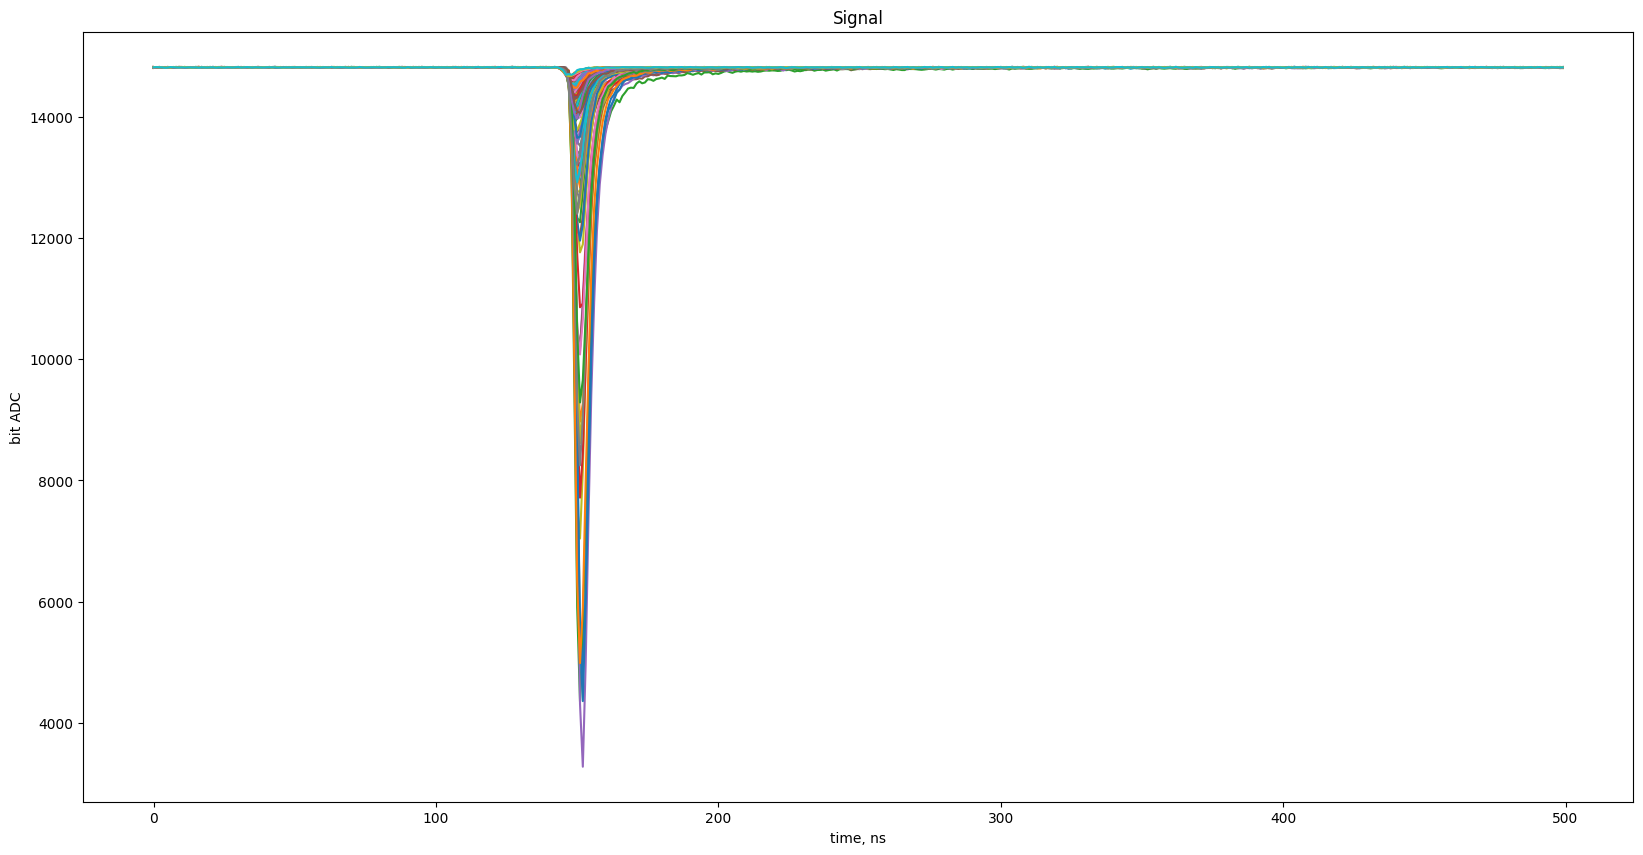

In [4]:
N=range(0,100)
ax = df.T[N].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Видим, что значимые данные расположены примерно со 140-го по 200-й столбцы.
Резвернем график и отобразим значимую часть

Text(0, 0.5, 'bit ADC')

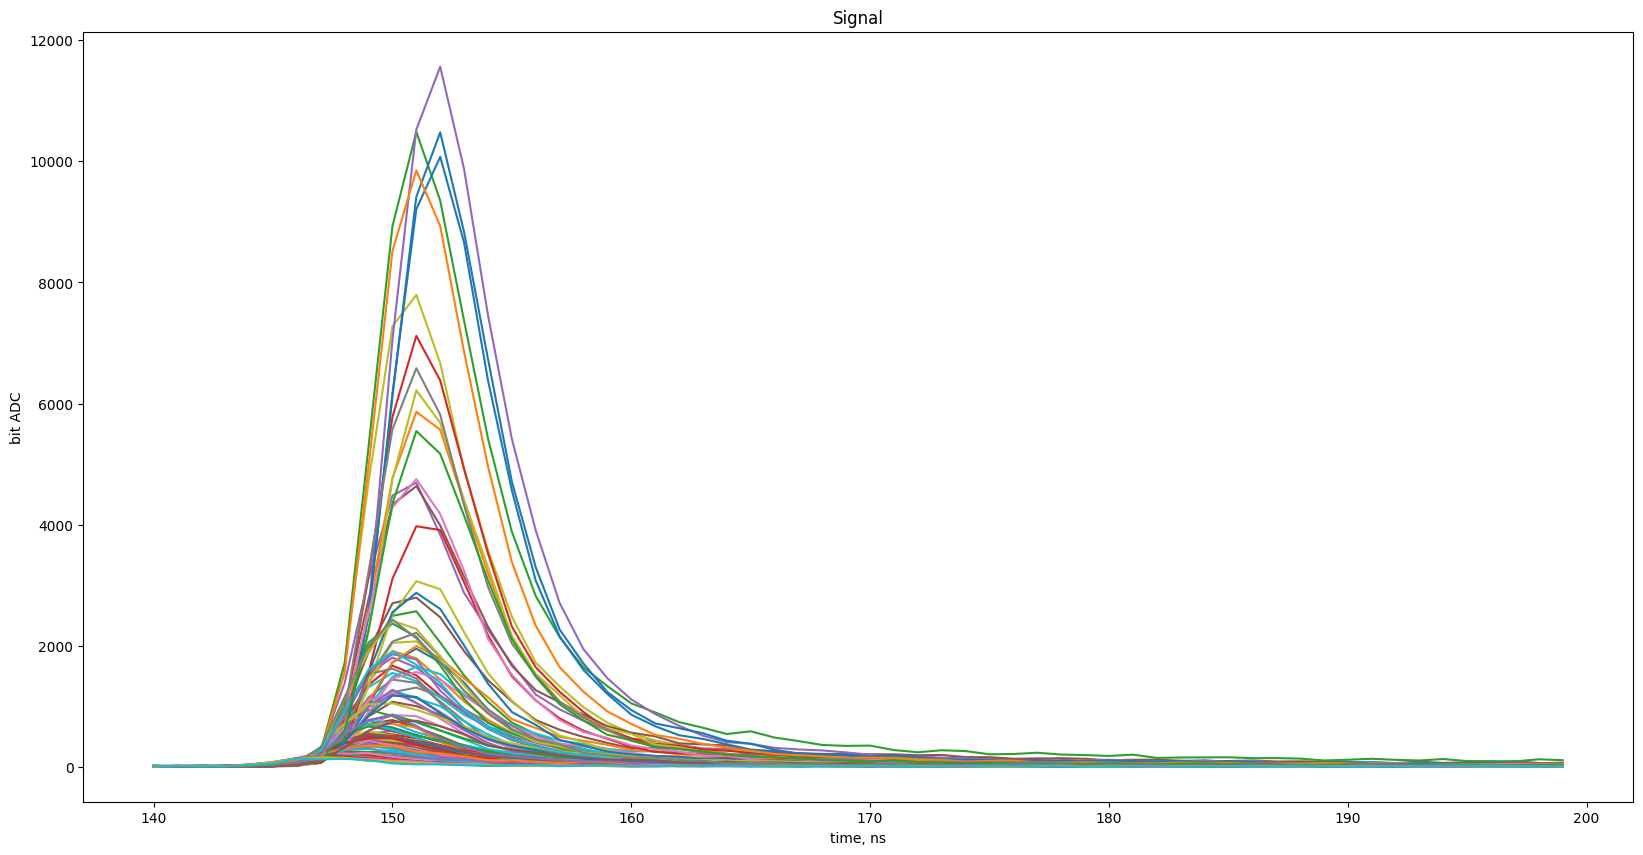

In [6]:
ax = (2**14-df.T[N]-1550)[140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")


Преобразуем датафрейм для дальнейшей работы с данными в таком виде.

In [7]:
df = 2**14-df-1550
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14,11,10,12,16,14,10,12,14,14,...,6,12,19,19,17,15,14,12,14,15
1,14,12,14,8,10,12,14,12,11,13,...,6,17,10,12,10,15,14,15,12,14
2,14,14,12,9,14,10,10,15,11,10,...,14,13,14,14,16,13,11,14,14,13
3,6,12,16,10,10,12,14,12,10,14,...,10,8,12,13,14,6,14,12,11,12
4,11,19,11,13,7,14,11,10,18,13,...,14,14,11,6,10,14,10,10,12,9


Добавим новый столбец, в который запишем максимальное значение в каждой строке

In [8]:
dataset = df.copy()
dataset['max'] = dataset.max(axis=1)
dataset['max'].describe()

count    23479.000000
mean      1846.138209
std       2389.308983
min        115.000000
25%        319.000000
50%        824.000000
75%       2326.000000
max      14834.000000
Name: max, dtype: float64

Видим, что максимальное значение 14834.
Найдем такие строки

In [9]:
max_df = dataset[dataset['max']==14834]
max_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,max
798,14,14,10,14,17,6,11,11,16,6,...,12,12,14,18,10,14,12,16,12,14834
6401,11,8,10,9,7,11,10,7,7,10,...,14,18,15,14,11,7,11,14,14,14834
9190,12,14,7,15,14,12,14,11,14,11,...,17,14,9,14,15,10,12,12,14,14834
9553,7,14,16,14,11,10,12,11,10,10,...,6,10,15,14,17,14,14,14,11,14834
11289,10,8,11,6,13,19,4,11,12,10,...,14,12,16,12,10,17,17,14,10,14834
13595,9,6,14,7,7,10,12,7,9,10,...,10,13,14,15,11,15,7,14,17,14834
17790,10,10,16,7,7,7,7,9,14,11,...,13,7,8,10,9,14,13,10,10,14834
22310,10,10,7,10,14,11,7,11,10,6,...,17,16,12,11,9,15,4,14,12,14834
23118,7,12,10,12,10,12,14,13,15,11,...,10,10,12,11,12,10,21,18,25,14834


Таких строк всего 9. Визуализируем их значимую часть, сохранив в переменную их индексы

Text(0, 0.5, 'bit ADC')

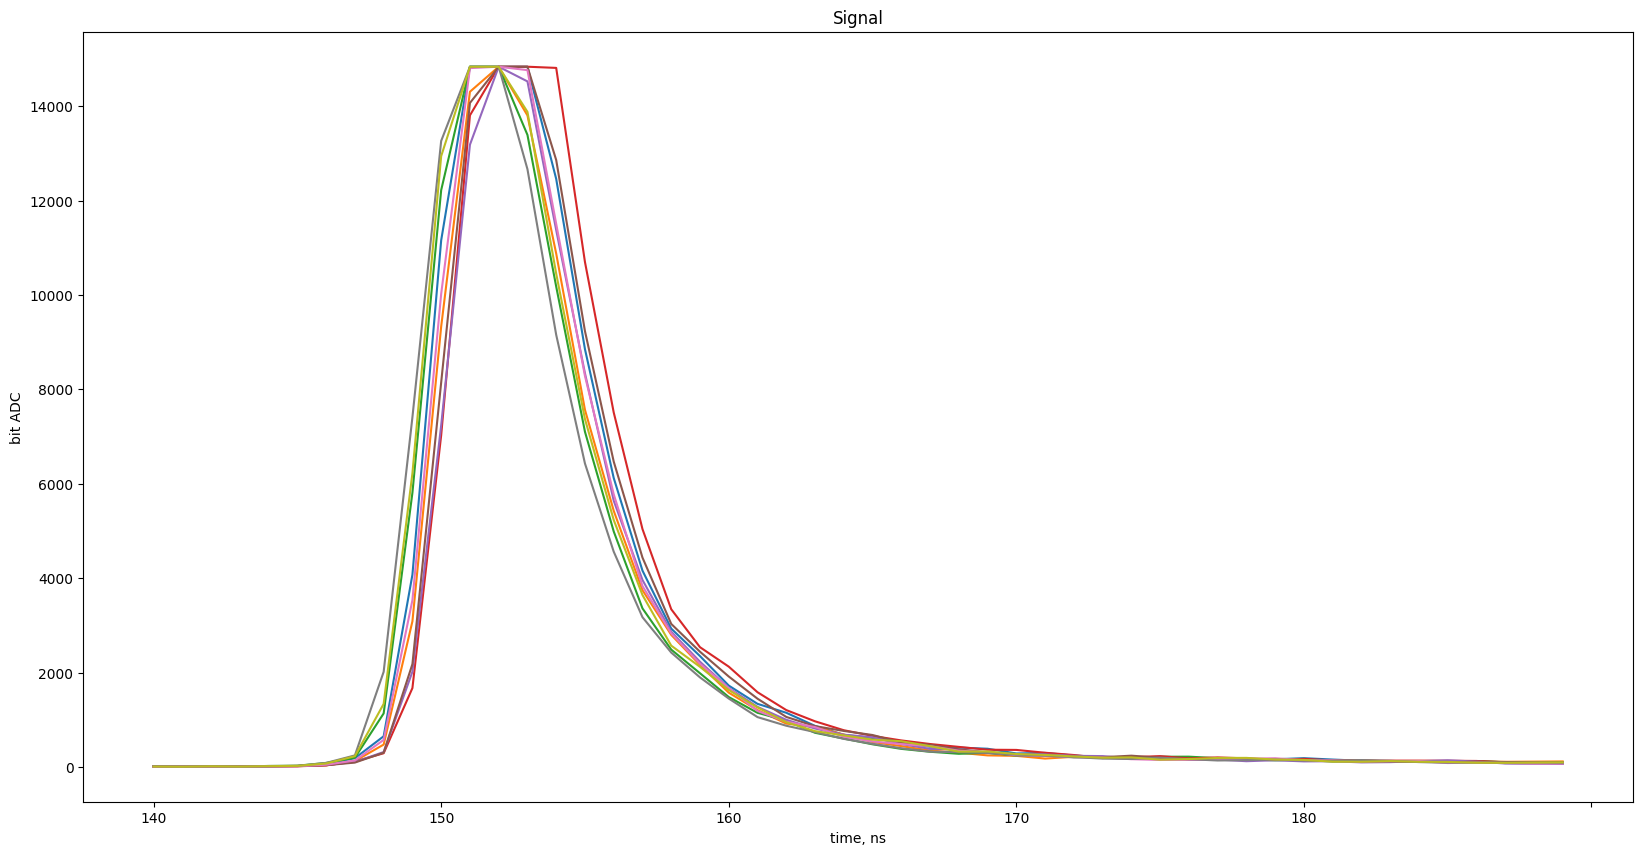

In [10]:
over_max_index = max_df.index.tolist()
ax = max_df.T[over_max_index][140:190].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Видим, что при значении 14834, данные образуют плато, что говорит о пределе чувствительности аппаратуры.
В конце кластеризации обозначим такие данные классом 2 (шумы)

In [11]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,max
0,14,11,10,12,16,14,10,12,14,14,...,12,19,19,17,15,14,12,14,15,543
1,14,12,14,8,10,12,14,12,11,13,...,17,10,12,10,15,14,15,12,14,1913
2,14,14,12,9,14,10,10,15,11,10,...,13,14,14,16,13,11,14,14,13,2570
3,6,12,16,10,10,12,14,12,10,14,...,8,12,13,14,6,14,12,11,12,576
4,11,19,11,13,7,14,11,10,18,13,...,14,11,6,10,14,10,10,12,9,1806


Поищем среди данных такие, где присутствует несколько пиков.

In [12]:
# Функция для подсчёта пиков в одной строке
def count_peaks(row, height=100, distance=100):
    peaks, _ = find_peaks(row, height=height, distance=distance)
    return len(peaks)

# Применяем функцию к каждой строке
peaks_per_row = df.apply(count_peaks, axis=1)

# Строки, где пиков > 1
multi_peak_rows = peaks_per_row[peaks_per_row > 1]
multi_peak_index = multi_peak_rows.index.tolist()
print("Строк с более чем одним пиком:", len(multi_peak_index))

Строк с более чем одним пиком: 2


Таких строки 2. Визуализируем данные

Text(0, 0.5, 'bit ADC')

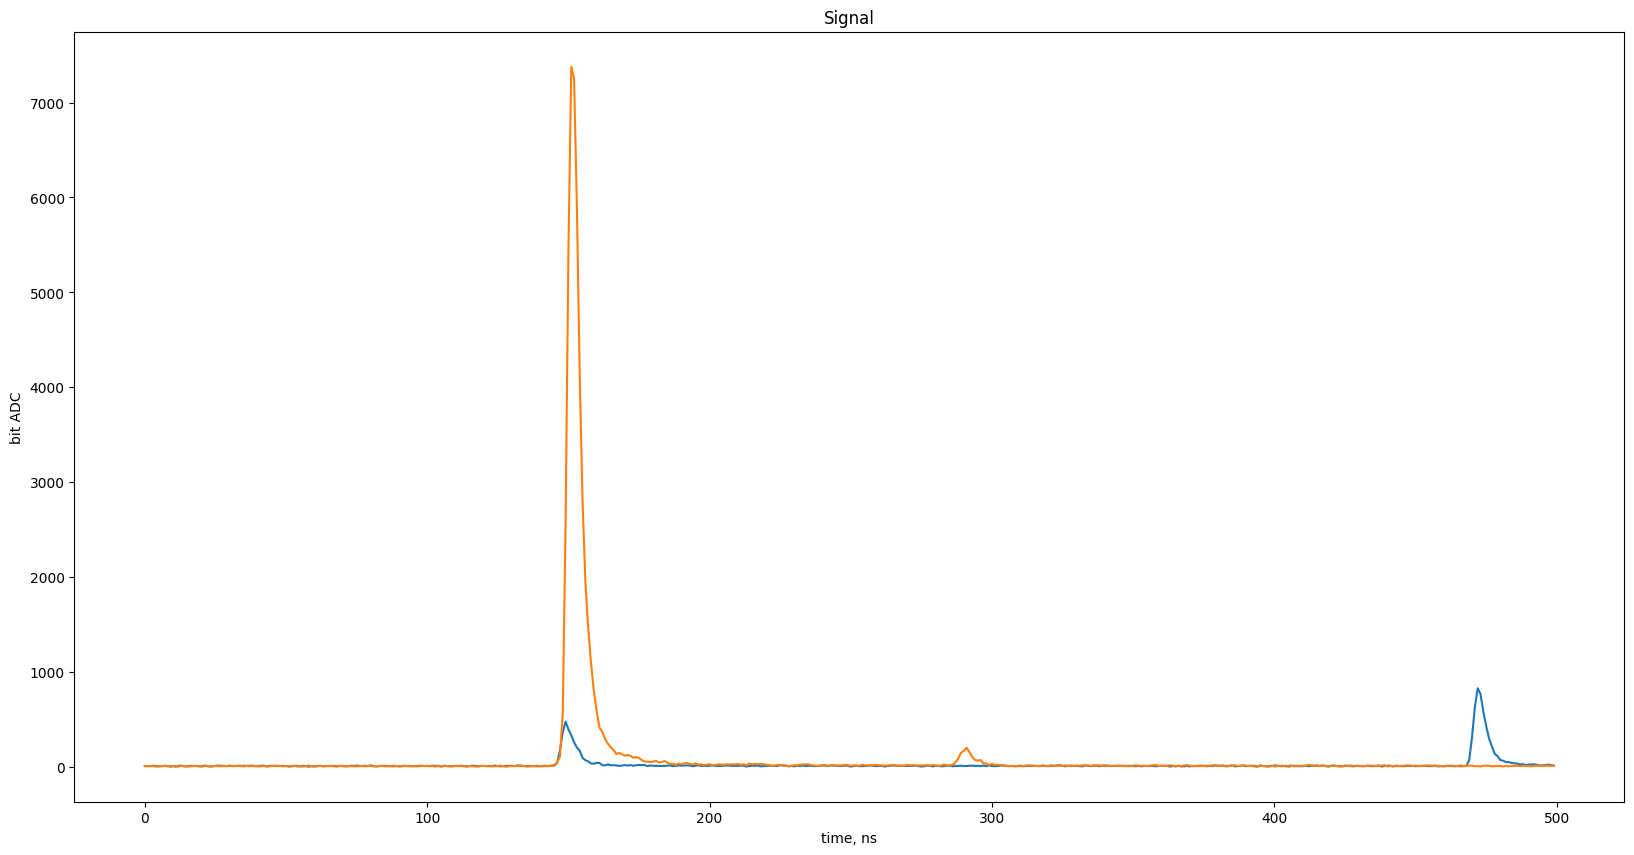

In [13]:
ax = df.T[multi_peak_index].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Действительно в этих данных присутствует второй пик. Такие строки тоже отнесем к классу шумов.


Добавим новый столбец, показывающий амплитуду колебаний в каждой строке

In [14]:
dataset['amplitude'] = dataset['max'] - dataset.iloc[:, :-1].min(axis=1)
dataset['amplitude'].describe()

count    23479.000000
mean      1842.849568
std       2389.075855
min        113.000000
25%        316.000000
50%        820.000000
75%       2322.500000
max      14833.000000
Name: amplitude, dtype: float64

In [15]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,max,amplitude
0,14,11,10,12,16,14,10,12,14,14,...,19,19,17,15,14,12,14,15,543,539
1,14,12,14,8,10,12,14,12,11,13,...,10,12,10,15,14,15,12,14,1913,1907
2,14,14,12,9,14,10,10,15,11,10,...,14,14,16,13,11,14,14,13,2570,2566
3,6,12,16,10,10,12,14,12,10,14,...,12,13,14,6,14,12,11,12,576,573
4,11,19,11,13,7,14,11,10,18,13,...,11,6,10,14,10,10,12,9,1806,1800


Также расчитаем в каждой строке площадь под кривой. Эта величина будет характеризовать скорость затухания.
Так как шаг между столбцами везде одинаков, мы можем условно принять его за единицу и считать площадь просто как сумму значений в строке.

In [18]:
dataset['square'] = dataset.iloc[:, :-2].sum(axis=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,max,amplitude,square
0,14,11,10,12,16,14,10,12,14,14,...,19,17,15,14,12,14,15,543,539,11592
1,14,12,14,8,10,12,14,12,11,13,...,12,10,15,14,15,12,14,1913,1907,20026
2,14,14,12,9,14,10,10,15,11,10,...,14,16,13,11,14,14,13,2570,2566,25565
3,6,12,16,10,10,12,14,12,10,14,...,13,14,6,14,12,11,12,576,573,10854
4,11,19,11,13,7,14,11,10,18,13,...,6,10,14,10,10,12,9,1806,1800,19697


Визуализируем данные по амплитуде и площади под кривой

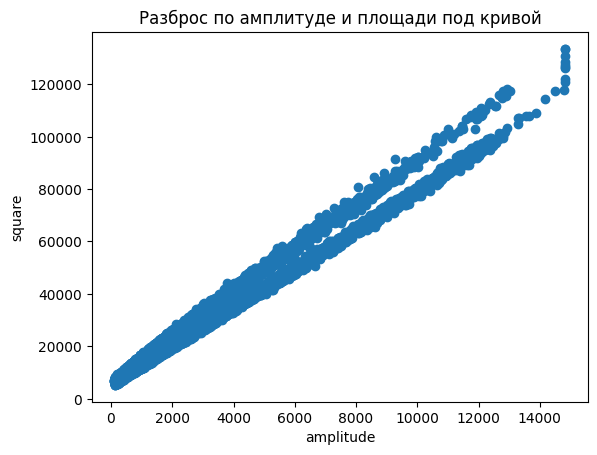

In [19]:
plt.scatter(dataset['amplitude'], dataset['square'])
plt.xlabel('amplitude')
plt.ylabel('square')
plt.title('Разброс по амплитуде и площади под кривой')
plt.show()

На графике с определенного момента видно четкое разделение на два класса.
Опираясь на эти показатели, разобъем данные на кластеры. Подготовим датафрейм

In [20]:
X = dataset[['amplitude', 'square']]
X.head()

,amplitude,square
0,539,11592
1,1907,20026
2,2566,25565
3,573,10854
4,1800,19697


Так как в дальнейшем применим PCA, проведем стандартизацию данных

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Выделим главные компоненты методом PCA

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Объясненная дисперсия:", pca.explained_variance_ratio_)

Объясненная дисперсия: [0.996229 0.003771]


Визуализируем значение компонент

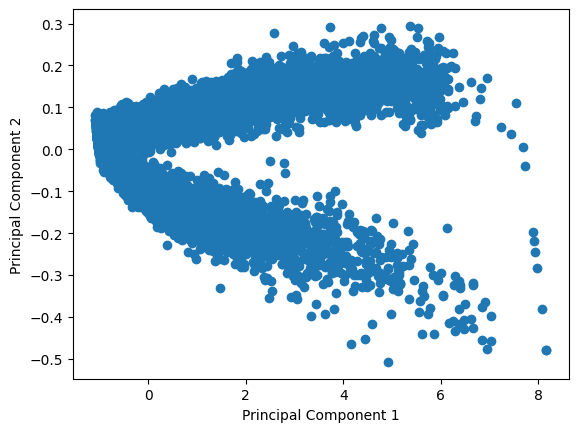

In [23]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Разделение на кластеры визуально стало четче.
Попробуем применить KMeans для разбиения на кластеры

In [27]:
kmeans = KMeans(n_clusters=2, n_init=100, random_state=42)
clusters = kmeans.fit_predict(X_pca)

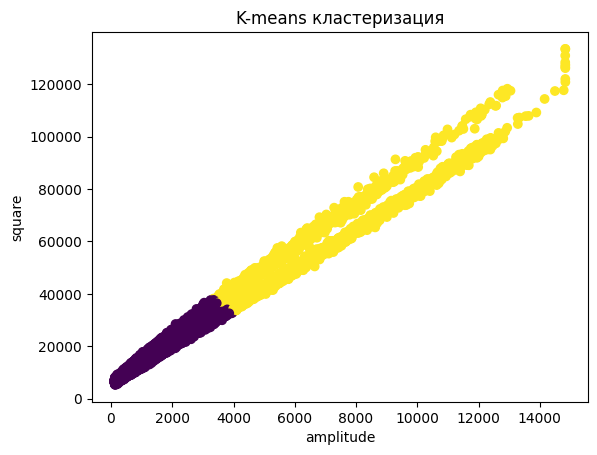

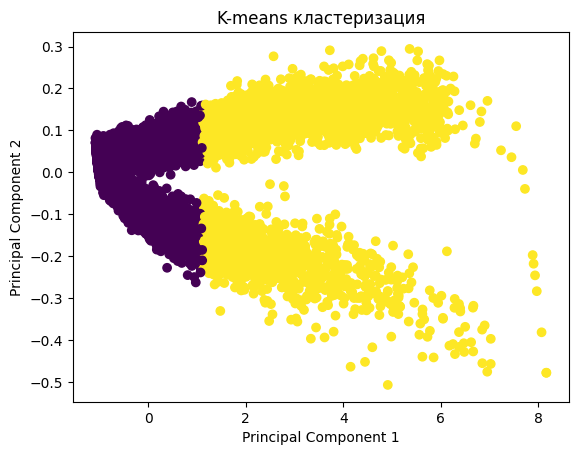

In [28]:
# Визуализация
plt.scatter(dataset['amplitude'], dataset['square'], c=clusters)
plt.xlabel('amplitude')
plt.ylabel('square')
plt.title('K-means кластеризация')
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means кластеризация')
plt.show()

KMean не справляется с таким разделением.
Попробуем агломеративную кластеризацию

In [31]:
agg = AgglomerativeClustering(n_clusters=2).fit(X_pca)
clusters = agg.labels_

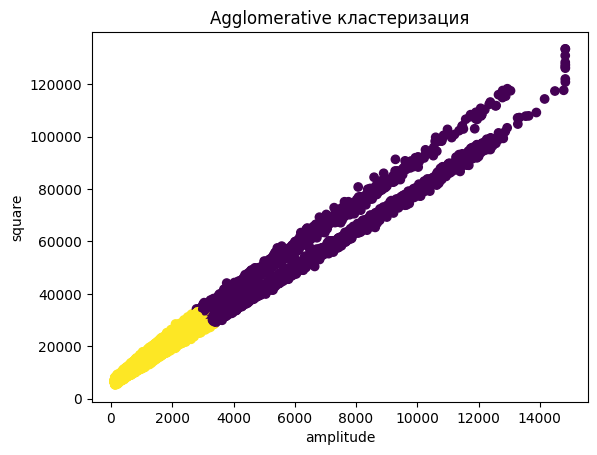

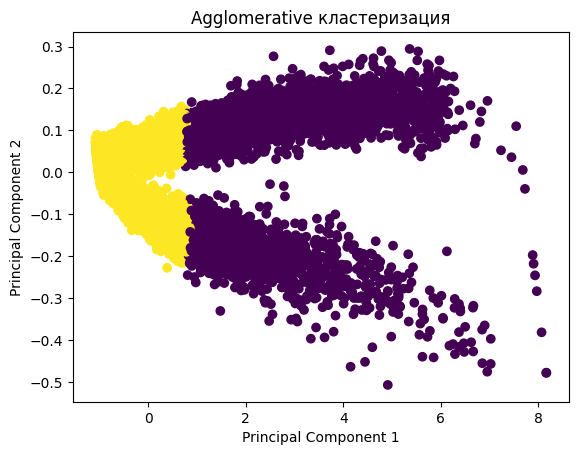

In [32]:
plt.scatter(dataset['amplitude'], dataset['square'], c=clusters)
plt.xlabel('amplitude')
plt.ylabel('square')
plt.title('Agglomerative кластеризация')
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative кластеризация')
plt.show()

Эта модель также не справилась.
Попробуем DBSCAN с разными гиперпараметрами.

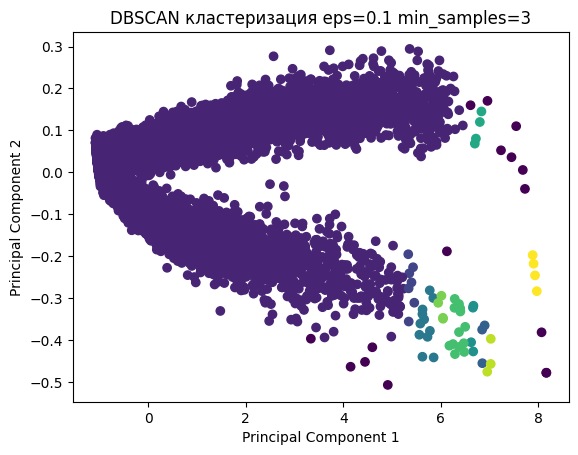

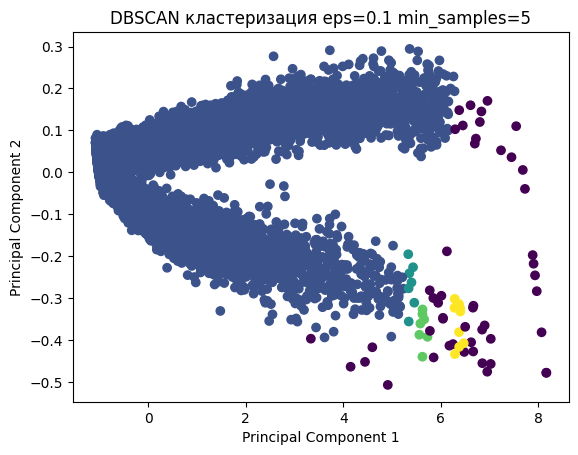

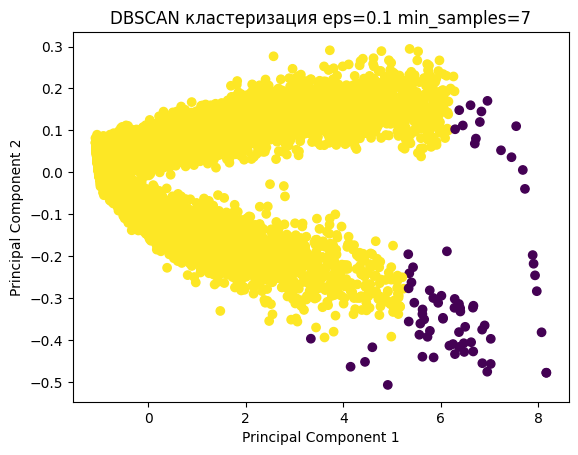

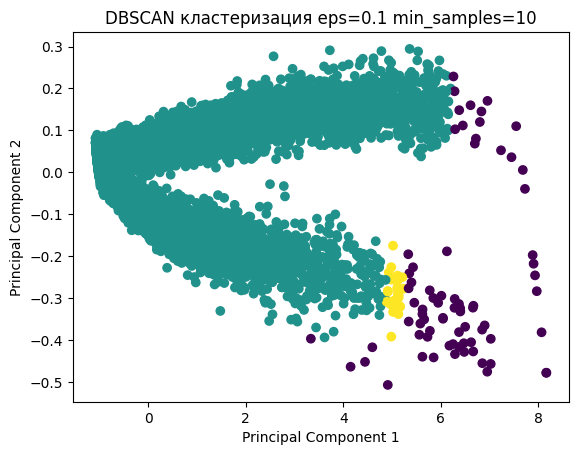

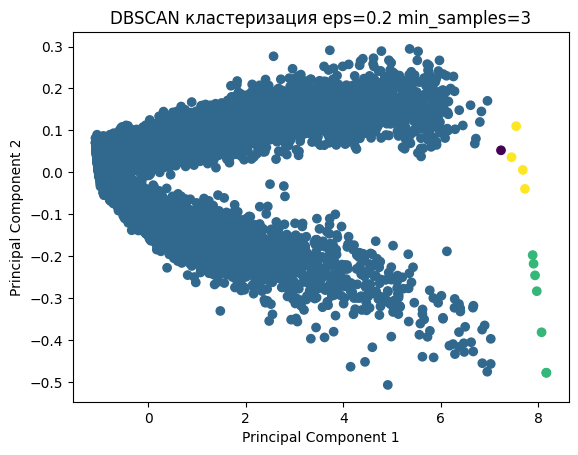

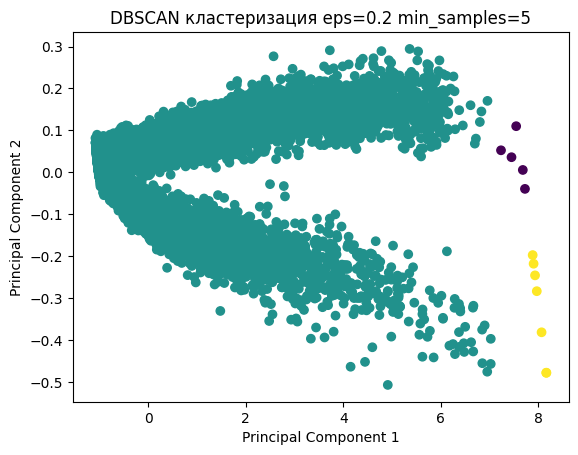

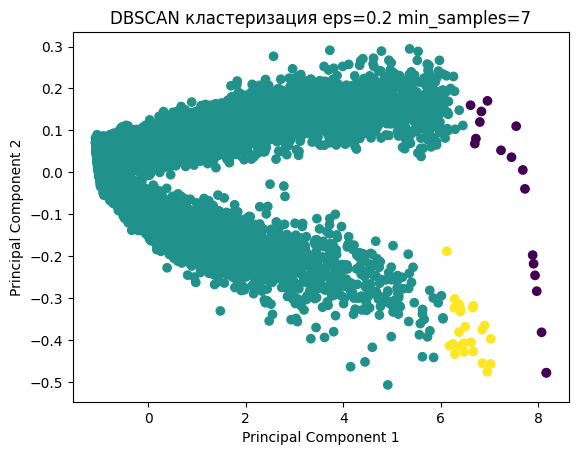

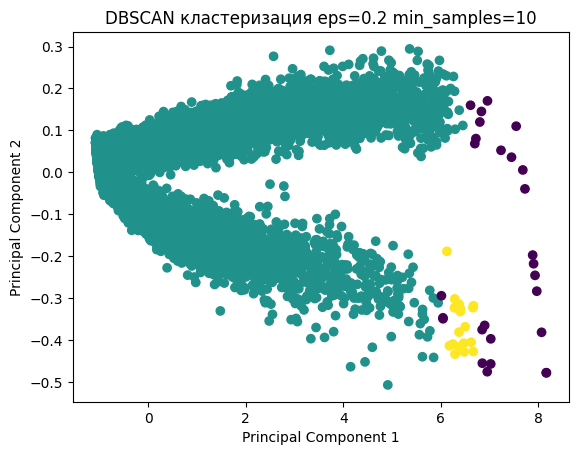

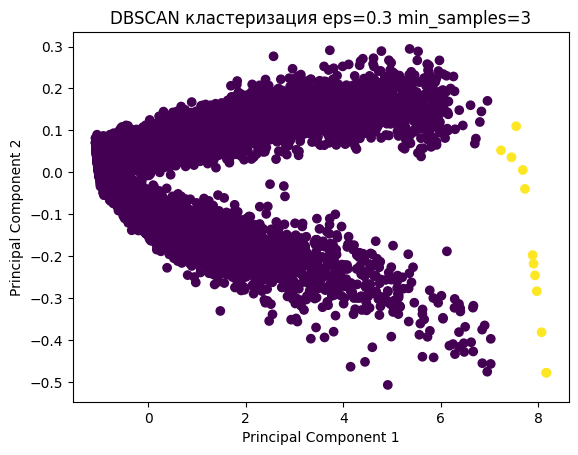

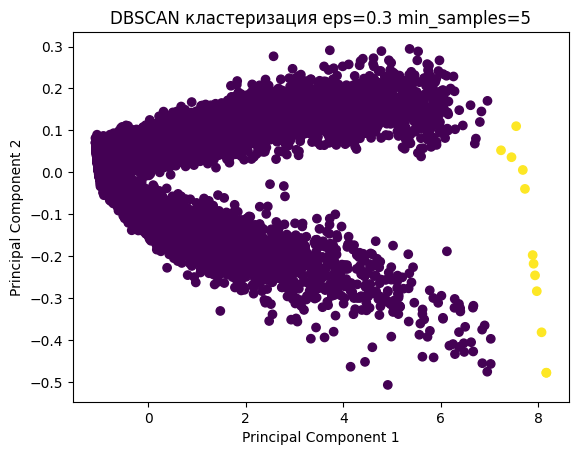

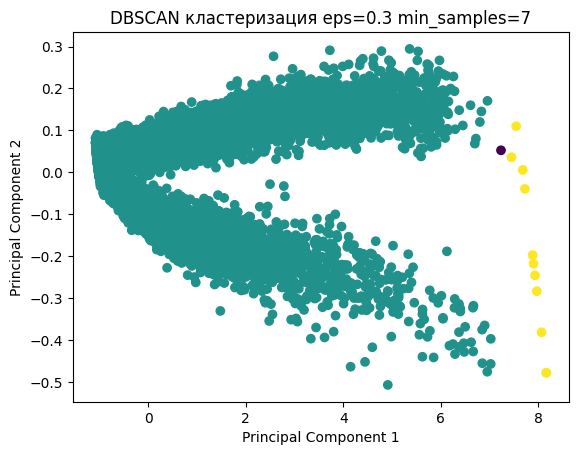

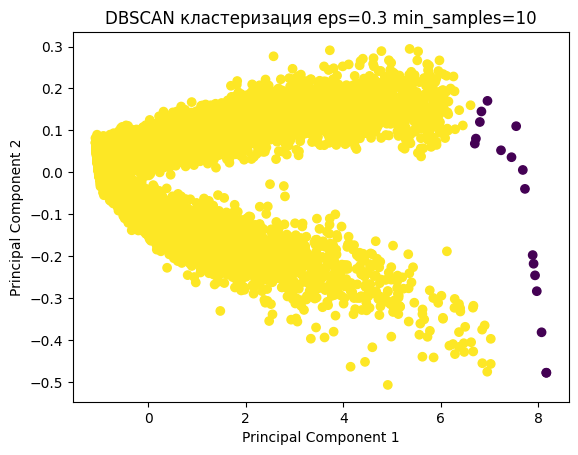

In [33]:
for i in [0.1, 0.2, 0.3]:
    for y in [3, 5, 7, 10]:
        dbscan = DBSCAN(eps=i, min_samples=y).fit(X_pca)
        clusters = dbscan.labels_
        # Визуализация
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'DBSCAN кластеризация eps={i} min_samples={y}')
        plt.show()

DBSCAN также не справился с такой структурой.
Попробуем GaussianMixture

In [34]:
gmm = GaussianMixture(n_components=2, init_params='k-means++', n_init=200).fit(X_pca)
clusters = gmm.predict(X_pca)

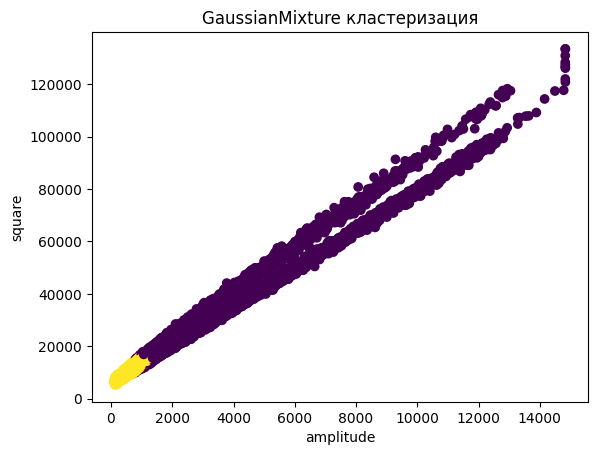

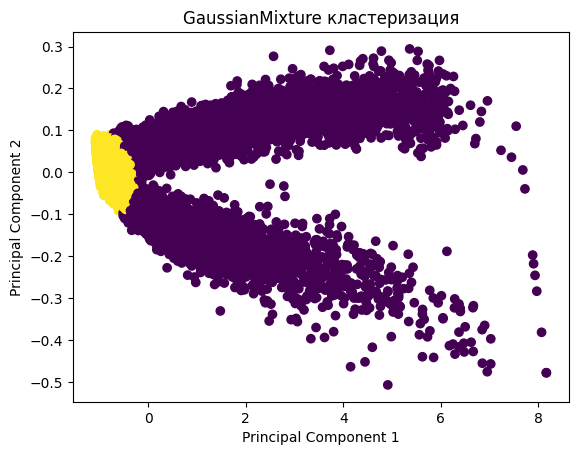

In [35]:
plt.scatter(dataset['amplitude'], dataset['square'], c=clusters)
plt.xlabel('amplitude')
plt.ylabel('square')
plt.title('GaussianMixture кластеризация')
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GaussianMixture кластеризация')
plt.show()

Помимо приведенных, я попробовал разные сочетания гиперпараметров во всех моделях, но так и не смог добиться правильного разделения моделями.
На графике PCA видно, что довольно точно можно разделить на два кластера просто проведя прямую по оси ординат в значении немного меньше 0.
Методом проб и ошибок наилучший результат удалось получить при пороговом значении второй главной компоненты в -0,015

In [36]:
# Создаём массив из единиц той же длины, что и исходный массив
clusters = np.ones(len(X_pca), dtype=int)  # [1, 1, 1, 1, 1]

# Заменяем 1 на 0 там, где второй компонент > -0.015
clusters[X_pca[:, 1] > -0.015] = 0

# проставляем класс шумов для данных, выходящих за границы чувствительности прибора
np.put(clusters, over_max_index, 2)
# и для строк с двумя пиками
np.put(clusters, multi_peak_index, 2)

Визуализируем, получившееся ручное разделение

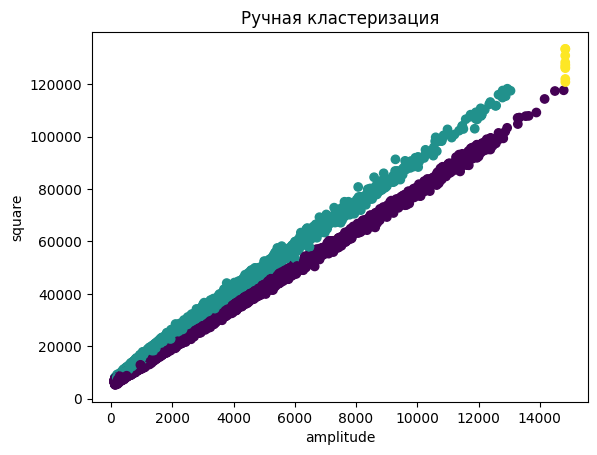

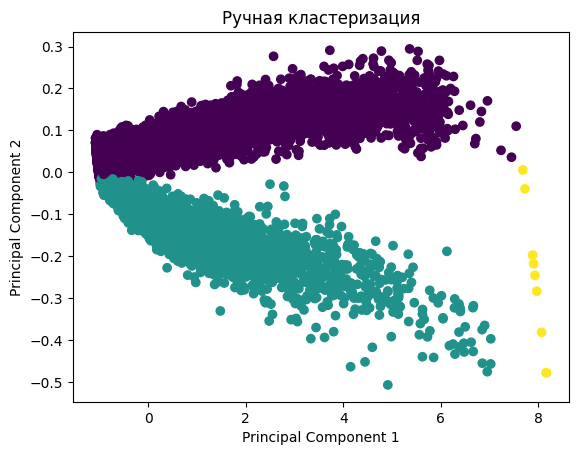

In [37]:
plt.scatter(dataset['amplitude'], dataset['square'], c=clusters)
plt.xlabel('amplitude')
plt.ylabel('square')
plt.title('Ручная кластеризация')
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Ручная кластеризация')
plt.show()

Как видим получилось довольно точное разделение.
Проверим начало массива классов

In [38]:
clusters[0:10]

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

Видим, что нам нужно инвертировать 0 и 1. Сделаем это и сохраним в файл

In [39]:
inverted = np.where((clusters == 0) | (clusters == 1), 1 - clusters, clusters)

# Преобразуем в DataFrame
df = pd.DataFrame({
    'index': np.arange(len(inverted)),  # Столбец индексов
    'cluster': inverted                 # Столбец значений
})

# Сохраняем в CSV
df.to_csv('submission.csv', index=False)